In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv('../drinking_water_potability.csv')
df.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

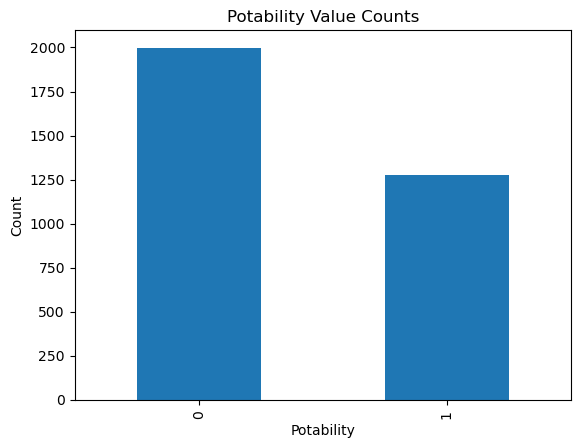

Potability
0    1998
1    1278
Name: count, dtype: int64


In [16]:
df['Potability'].value_counts().plot(kind='bar')
plt.xlabel('Potability')
plt.ylabel('Count')
plt.title('Potability Value Counts')
plt.show()
print(df['Potability'].value_counts())

## **Balanceo de clases**

In [ ]:
from sklearn.utils import resample

df_majority = df[df.Potability==0]
df_minority = df[df.Potability==1]

df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])

In [ ]:
df_balanced['Potability'].value_counts().plot(kind='bar')

## **Predictorias y targets**

In [17]:
X = df_balanced.drop('Potability', axis=1)
y = df_balanced['Potability']

In [ ]:
X

## **Normalización de datos**

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns = X.columns
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=columns)

In [19]:
X_scaled

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,0.505771,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091
1,0.265434,0.297400,0.300611,0.491839,0.581699,0.719411,0.497319,0.450999,0.576793
2,0.578509,0.641311,0.321619,0.698543,0.581699,0.414652,0.562017,0.532866,0.303637
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327
...,...,...,...,...,...,...,...,...,...
3271,0.333436,0.530482,0.775947,0.533436,0.656047,0.603192,0.448062,0.535037,0.564534
3272,0.557775,0.530016,0.279263,0.603473,0.581699,0.368912,0.678284,0.532673,0.254915
3273,0.672822,0.465486,0.539101,0.547807,0.581699,0.438152,0.338662,0.560655,0.349570
3274,0.366197,0.664407,0.191490,0.465860,0.581699,0.387157,0.343638,0.622659,0.616120


## **Separación de train y test**

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## **Función para medir el error**

In [21]:
from sklearn.metrics import roc_auc_score

def mide_error(model_name, y_pred):
    auc = roc_auc_score(y_test, y_pred)
    print(f'{model_name} AUC: {auc:.4f}')

# **Modelo**

## **MLP**

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [23]:
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 100),     # Tamaño de las capas ocultas
    activation='relu',                  # Función de activación de las neuronas
    solver='adam',                      # Algoritmo de optimización
    alpha=0.0001,                       # Término de regularización L2
    batch_size='auto',                  # Tamaño del lote de entrenamiento
    learning_rate='constant',           # Tasa de aprendizaje
    learning_rate_init=0.001,           # Tasa de aprendizaje inicial
    power_t=0.5,                        # Exponente para la tasa de aprendizaje inversa
    max_iter=200,                       # Número máximo de iteraciones
    shuffle=True,                       # Barajar muestras en cada iteración
    random_state=42,                    # Semilla aleatoria para reproducibilidad
    tol=0.0001,                         # Tolerancia para la convergencia
    verbose=False,                      # Imprimir mensajes de progreso
    warm_start=False,                   # Inicialización cálida
    momentum=0.9,                       # Término de impulso para el descenso del gradiente
    nesterovs_momentum=True,            # Usar momentum de Nesterov
    early_stopping=False,               # Detener el entrenamiento temprano si no mejora
    validation_fraction=0.1,            # Fracción de datos utilizados para la validación
    beta_1=0.9,                         # Tasa de decaimiento exponencial para estimaciones de primer orden
    beta_2=0.999,                       # Tasa de decaimiento exponencial para estimaciones de segundo orden
    epsilon=1e-08,                      # Valor pequeño para la estabilidad numérica
    n_iter_no_change=10,                # Número máximo de iteraciones sin mejora
    max_fun=15000                       # Número máximo de evaluaciones de la función objetivo
)

mlp.fit(X_train, y_train)

y_pred = mlp.predict_proba(X_test)[:, 1]

mide_error('MLP', y_pred)

MLP AUC: 0.6647


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## **AdaBoostClassifier (Decision tree) + MLP con Voting Classifier**

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [25]:
mlp = MLPClassifier(random_state=42)
hist_gradient_boosting = HistGradientBoostingClassifier(random_state=42)

In [26]:
ensemble_model = VotingClassifier(estimators=[('mlp', mlp), ('hgb', hist_gradient_boosting)], voting='soft')

In [27]:
param_grid = {
    'mlp__hidden_layer_sizes': [(100,), (100, 100)],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.001, 0.01],
    'hgb__max_iter': [100, 200],
    'hgb__max_depth': [5, 10]
}

In [28]:
grid_search = GridSearchCV(ensemble_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('mlp',
                                                     MLPClassifier(random_state=42)),
                                                    ('hgb',
                                                     HistGradientBoostingClassifier(random_state=42))],
                                        voting='soft'),
             param_grid={'hgb__max_depth': [5, 10], 'hgb__max_iter': [100, 200],
                         'mlp__alpha': [0.0001, 0.001, 0.01],
                         'mlp__hidden_layer_sizes': [(100,), (100, 100)],
                         'mlp__learning_rate_init': [0.001, 0.01]},
             scoring='accuracy')

In [29]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [30]:
y_pred = best_model.predict(X_test)

In [31]:
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud del mejor modelo en el conjunto de prueba:", accuracy)
print("Mejores hiperparámetros:", best_params)

Exactitud del mejor modelo en el conjunto de prueba: 0.6844512195121951
Mejores hiperparámetros: {'hgb__max_depth': 10, 'hgb__max_iter': 100, 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate_init': 0.01}


**Encontrar mejores hiperparametros**

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from scipy.stats import uniform

# Define el modelo MLP
mlp = MLPClassifier()

# Define la distribución de hiperparámetros a buscar
param_dist = {
    'hidden_layer_sizes': [(100,), (100, 100)],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate_init': uniform(0.001, 0.01),
    'max_iter': [100, 200]
}

# Realiza la búsqueda aleatoria
random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy')
random_search.fit(X_train, y_train)

# Obtiene el mejor modelo y los mejores hiperparámetros
best_model = random_search.best_estimator_
best_params = random_search.best_params_


c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

In [33]:
print("Mejores hiperparámetros:", best_params)
print("Mejores hiperparámetros:", best_model)

Mejores hiperparámetros: {'alpha': 0.003132298023397408, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.006079821202913575, 'max_iter': 100}
Mejores hiperparámetros: MLPClassifier(alpha=0.003132298023397408, hidden_layer_sizes=(100, 100),
              learning_rate_init=0.006079821202913575, max_iter=100)


**MLP con mejores hiperparametros**

In [34]:
from sklearn.neural_network import MLPClassifier

best_model = MLPClassifier(alpha=0.004691546592834658,
                            learning_rate_init=0.009023557986183942,
                            max_iter=100,
                            random_state=42)

best_model.fit(X_train, y_train)  # Entrenar el modelo con los datos de entrenamiento

y_pred = best_model.predict(X_test)  # Realizar predicciones en los datos de prueba



c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
mide_error('MLP', y_pred)

MLP AUC: 0.5941


**Ejemplo de RNN (Red Neuronal Recurrente):**

In [36]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense


In [37]:
# Definir el modelo RNN
model = Sequential()

# Capa recurrente
model.add(SimpleRNN(32, input_shape=(None, 1), activation='relu'))

# Capa densa de salida
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

# Imprimir la precisión en el conjunto de prueba
accuracy = history.history['val_accuracy'][-1]  # Obtiene la precisión en la última época
print("Precisión en el conjunto de prueba:", accuracy)


Epoch 1/100
82/82 [==============================] - 2s 8ms/step - loss: 0.6836 - accuracy: 0.5607 - val_loss: 0.6618 - val_accuracy: 0.6280
Epoch 2/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.6053 - val_loss: 0.6630 - val_accuracy: 0.6280
Epoch 3/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.6053 - val_loss: 0.6608 - val_accuracy: 0.6280
Epoch 4/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6701 - accuracy: 0.6053 - val_loss: 0.6597 - val_accuracy: 0.6280
Epoch 5/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6690 - accuracy: 0.6053 - val_loss: 0.6590 - val_accuracy: 0.6280
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.6080 - val_loss: 0.6566 - val_accuracy: 0.6311
Epoch 7/100
82/82 [==============================] - 0s 3ms/step - loss: 0.6651 - accuracy: 0.6172 - val_loss: 0.6543 - val_accuracy: 0.6418
Epoch 8/100
8